# Probabilistic Programming with Haskell

Siddhart Bath, Simeon Carstens, Matthias Meschede

_first published on www.tweag.io/blog_

#### imports

In [1]:
:e OverloadedStrings
:e ExistentialQuantification

import System.Random.MWC (createSystemRandom)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL
import Data.Text (Text, pack)

import Control.Monad (liftM2, replicateM, forM, forM_)
import Control.Monad.IO.Class (liftIO)
import Data.List (sort)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Inference.SMC as SMC
import Control.Monad.Bayes.Inference.RMSMC as RMSMC
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Traced.Static (Traced)
import Control.Monad.Bayes.Inference.SMC

import Numeric.Log
import Control.Monad.Bayes.Class

import Data.List (partition)

#### Plotting

In [2]:
barPlot :: Text -> VL.VLSpec
barPlot xName = 
    let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal]
            . VL.position VL.Y [VL.PName "binnedData", VL.PAggregate VL.Count, VL.PmType VL.Quantitative, VL.PAxis [VL.AxTitle "count"]]
    in VL.asSpec [VL.mark VL.Bar [VL.MOpacity 1.0, VL.MColor "#a3c6de"], encoding []]

linePlot :: Text -> Text -> VL.VLSpec
linePlot xName yName = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative]
  in VL.asSpec [VL.mark VL.Line [VL.MColor "blue"], encoding []]

scatterBlue xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "blue"], encoding []]
  
scatterGreen xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "green"], encoding []]
  
scatterPlotWithColor :: Text -> Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
scatterPlotWithColor xName yName zName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
            . VL.color [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Circle [], encoding []]

density2DPlot :: Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
density2DPlot xName yName (xmin, xmax) (ymin, ymax) = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent xmin xmax], VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent ymin ymax], VL.PmType VL.Quantitative]
            . VL.color [ VL.MAggregate VL.Count, VL.MName "col", VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]

imagePlot :: Text -> Text -> Text -> VL.VLSpec
imagePlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal, VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Nominal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]
  
imageFacetPlot :: Text -> Text -> Text -> VL.VLSpec
imageFacetPlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Ordinal, VL.PAxis [VL.AxGrid False]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Ordinal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGrid False]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]], VL.MLegend [VL.LOrient VL.LOBottom]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LOrient VL.LOBottom, VL.LDirection VL.Horizontal, VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding [], VL.width 200,  VL.height 100]

data SpecGrid = H [[VL.VLSpec]] | V [[VL.VLSpec]] | L [VL.VLSpec] | S VL.VLSpec | F (Text, Int, VL.VLSpec)

data InputData = Cols [(Text, VL.DataValues)]
               | File FilePath

plot :: (Double, Double) -> SpecGrid -> InputData -> VL.VegaLite
plot (figw,figh) specGrid dataPoints =
    let description = VL.description "Plot"
        dat' = case dataPoints of
            Cols cols -> foldl (.) (VL.dataFromColumns []) (map (uncurry VL.dataColumn) cols) []
            File fp -> VL.dataFromSource (pack fp) []
        configure = VL.configure
            . VL.configuration (VL.Axis
                                        [ VL.Domain False,
                                          VL.LabelColor "#7F7F7F",
                                          VL.LabelPadding 4,
                                          VL.TickColor "#7F7F7F",
                                          VL.TickSize 5.67,
                                          VL.Grid True,
                                          VL.GridColor "#FFFFFF"
                                          ])
        spec = case specGrid of
            S s -> VL.layer [s]
            L ls -> VL.layer ls
            H lss -> VL.hConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            V lss -> VL.vConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            F (_, _, s) -> VL.specification s
        facet = case specGrid of
            F (field, nColumns, _) -> [VL.columns $ fromIntegral nColumns, VL.facetFlow [VL.FName field, VL.FmType VL.Nominal]]
            _   -> [VL.width figw,  VL.height figh]
    in VL.toVegaLite $ [VL.background "#f9f9f9", configure [], description, dat', spec] ++ facet

## Part 2: Linear Regression

This post is a continuation of Tweag's _**Probabilistic Programming with monad‑bayes Series**_. You can find {Part 1 here](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html).
Want to make this post interactive? Try our [notebook version](https://github.com/tweag/blog-resources/tree/master/monad-bayes-series). It includes a Nix shell, the required imports, and some helper routines for plotting. Let's start modeling!

### Modeling

The lawn is wet, did it rain?
The ground moves, is there an earthquake?
Prices rise, are we in an economic crisis?
Wiggly lines appear on the screen, did a black hole perturb gravity on Earth?
Patterns emerge in software [dependency graphs](https://www.tweag.io/posts/2019-02-06-mapping-open-source.html) and [source code](https://www.tweag.io/posts/2019-08-01-codestatistics-umap.html), is this the outcome of a particular development style?
Evidence is found in a legal discovery procedure, is anyone guilty of wrongdoing?

We continuously make observations similar to "the lawn is wet".
Such data touches our senses either directly, or indirectly through a measurement device.
It is visible, concrete, and therefore unquestioned here—contrary to the invisible and abstract processes that might have generated it.

Neither can every process generate this data—
earthquakes don't (usually) wet the lawn, black holes don't (yet) influence prices, and legal malpractice doesn't (often) bring about specific source code patterns—
nor is there a unique process that can generate it:
earthquakes and black holes can both move the ground; sprinklers and rain can wet the lawn equally well.
Hence, a process implies data, but data doesn't imply a process.

The conclusion is that we can't conclude that a single process is behind the data, but processes aren't indistinguishable either.
We can _compare_ them by assessing how likely it is that they generate the data.
Bayesian inference and the laws of probability tell us _how_ to make this comparison rationally.

Conceptually it is simple:
Define a set of processes that we want to compare and prior beliefs in each of them (the _prior distribution_). 
For each of these processes, describe and compute the probability that it generates the observed data (the _likelihood_).
Score each process - that is multiply the prior belief in a process with the likelihood.
Renormalize and examine the result, the posterior beliefs in each model (the _posterior distribution_).

In this blog post, we walk through this process step by step with [`monad-bayes`](https://github.com/adscib/monad-bayes#readme).
First, we set up a _statistical model_ that describes an ensemble of data generation processes.
Then, we generate synthetic data with one specific process in this ensemble.
From this data, we try to infer which process we have used from the ones that our statistical model describes.

### Model Setup

The data that we consider are two-dimensional points (x, y).
These points could be observations of time and velocity, location and temperature, velocity and acceleration, or any other two continuous variables that we observe.
Here is how we can describe such data with Haskell:

In [13]:
data Data
  = Data
      { xValue :: Double,
        yValue :: Double
      }
  deriving (Eq, Show)

The model that we consider generates data along lines with some Gaussian noise around.
This means that the x and y values of our data points cannot take any value, but that `y` can be calculated from `x` with the equation `m*x + b + n`, with parameters `m,b` that are the same for all points and a random, normally-distributed deviation `n` that is independently drawn for each point.
In Haskell, the model, i.e., the lines that it describes, can thus be characterized with:

In [14]:
data Params
  = Params
      { slope :: Double,
        intercept :: Double,
        noiseStd :: Double
      }
  deriving (Eq, Show)

The likelihood, the heart of our model, corresponds to this succinct Haskell function:

In [15]:
likelihood :: Params -> Data -> Log Double
likelihood (Params m b nStd) (Data x y) = normalPdf (m*x + b) nStd y

It describes the probability (`Log Double`) to observe some data (`Data`) given some model parameters (`Params`).
In our case, it's just a Gaussian distribution (`normalPdf`), centered at `m*x + b` for a given `x` and standard deviation `nStd`.
That's it—the model definition is unspectacular and short.

### The Model As A Family Of Distributions

For a given value of `Params`, `likelihood` provides us with the (log-)probability for a `Data` point.
In other words, it describes a probability distribution.
We can pick data samples from such a _sampling distribution_—modeling a real-world data generating process.
For instance, let's choose the following parameters:

In [16]:
 params0 = Params {slope=2.3, intercept=(-1.2), noiseStd=2.0} 

Line 1: Redundant bracket
Found:
Params{slope = 2.3, intercept = (-1.2), noiseStd = 2.0}
Why not:
Params{slope = 2.3, intercept = -1.2, noiseStd = 2.0}

The associated sampling distribution can then be obtained with:

In [17]:
samplingDistribution' :: Data -> Double
samplingDistribution' = exp . ln . likelihood params0

The extra `exp . ln` snippet here is required to extract a `Double` from a `Log Double`, a data type that internally stores the logarithm of a number instead of the actual value.
Here is a plot that shows how this 2D sampling distribution looks like:

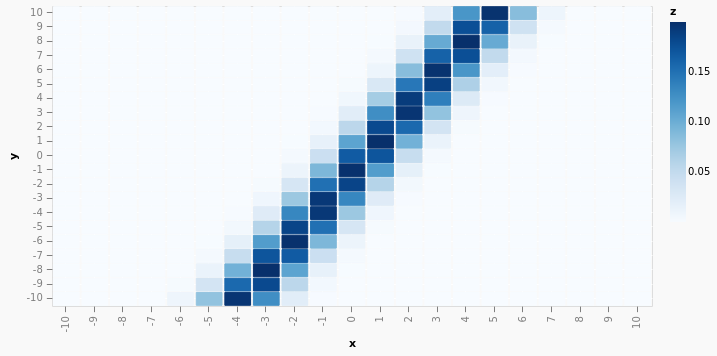

In [18]:
points1 = [(x, y, samplingDistribution' (Data x y)) | x<-[-10..10], y<-[-10..10]]

vlShow $ plot (600, 300)
              (L [imagePlot "x" "y" "z"])
              (Cols [("x", VL.Numbers ((\(x, _, _)->x) <$> points1)),
                     ("y", VL.Numbers ((\(_, x, _)->x) <$> points1)),
                     ("z", VL.Numbers ((\(_, _, x)->x) <$> points1))])
-- this plot needs a newer version of jupyterlab and Vega. To see
-- the correct version, click on the 3 points in the upper right
-- corner and open it in the vega editor

You can think about it as a line with some noise around, or as a Gaussian distribution with fixed standard deviation in `y` direction and a mean that increases linearly with `x`, which is closer to the definition.

Our statistical model doesn't just describe a single distribution but a different one for each value of `Params`.
A bunch of `Params` therefore corresponds to a bunch of sampling distributions.
Or, expressed more confusingly, a distribution of `Params` corresponds to a distribution of sampling distributions.
Take, for example, a distribution of `Params` that we call `priorParams` where slope, intercept and noise standard deviation are drawn from uniform distributions:

In [19]:
priorParams :: MonadSample m => m Params
priorParams = do
  intercept <- uniform (-5) 5
  slope <- uniform (-5) 5
  noise <- uniform 1 3
  return $ Params slope intercept noise

We can draw a few parameters from this model parameter distribution:

In [20]:
mkSampler = replicateM 9
params <- sampleIOfixed $ mkSampler priorParams

And compute and plot the corresponding sampling distributions for each parameter sample in the domain `x=[-10, 10]` and `y=[-10, 10]`:

Line 2: Move guards forward
Found:
[(iparam, x, y, prob (Data x y)) | x <- [-10, -9.5 .. 10],
 y <- [-10, -9.5 .. 10], let prob = exp . ln . likelihood param]
Why not:
[(iparam, x, y, prob (Data x y)) |
 let prob = exp . ln . likelihood param, x <- [-10, -9.5 .. 10],
 y <- [-10, -9.5 .. 10]]

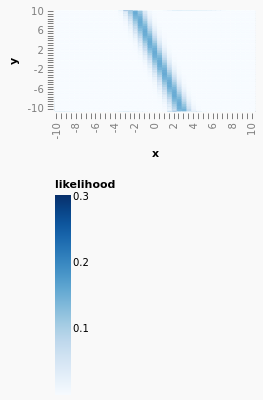

In [21]:
points2 =
  [ [ (iparam, x, y, prob (Data x y))
      | x <- [-10, -9.5 .. 10],
        y <- [-10, -9.5 .. 10],
        let prob = exp . ln . likelihood param
    ]
    | (iparam, param) <- zip [0 ..] params
  ]

is = mconcat $ (map . map) (\(i, _, _, _) -> i) points2
xs = mconcat $ (map . map) (\(_, x, _, _) -> x) points2
ys = mconcat $ (map . map) (\(_, _, y, _) -> y) points2
zs = mconcat $ (map . map) (\(_, _, _, z) -> z) points2

vlShow $ plot (600, 300)
              (F ("iParam", 3, imageFacetPlot "x" "y" "likelihood"))
              (Cols [("iParam", VL.Numbers is),
                     ("x", VL.Numbers xs),
                     ("y", VL.Numbers ys),
                     ("likelihood", VL.Numbers zs)])
-- this plot needs a newer version of jupyterlab and Vega. To see
-- the correct version, click on the 3 points in the upper right
-- corner and open it in the vega editor

Each distribution varies in terms of its slope, intercept and standard deviation.
Note that the maximum of a distribution is lower if it has a higher standard deviation, which is due to the normalized `normalPdf` function we used.
However, we didn't properly normalize these distributions within the limited 2D domain but that's not important for what is coming.
The important point to understand is that our `likelihood` model describes a family of distributions which are parametrized through `Params`.

### Generating Data - MCMC

Now let's pick one of those distributions, the one with `Params {slope=2.3, intercept=(-1.2), noiseStd=2.0}` that we showed initially, and draw some synthetic data samples from it.

To sample with `monad-bayes`, we express `likelihood` directly as a distribution.
This means, `likelihood :: Params -> Data -> Log Double` becomes `likelihoodDist :: Params -> m Data`.
Here, `m` implements the `MonadInfer` typeclass that represents a distribution from which we can sample.
It thus somehow deals with the `Log Double` probability behind the scenes:

In [22]:
likelihoodDist :: MonadInfer m => Params -> m Data
likelihoodDist params = do
  x <- uniform (-10) 10
  y <- uniform (-10) 10
  score $ likelihood params (Data x y)
  return $ Data x y

As we did in our [previous blog post](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html), we can sample from this distribution with [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo):

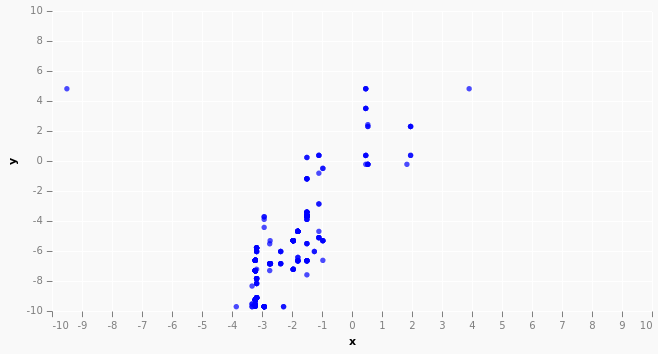

In [23]:
mkSampler = prior . mh 300
pointsMCMC <- sampleIOfixed $ mkSampler $ likelihoodDist params0

vlShow $ plot (600, 300)
              (L [scatterBlue "x" "y" (-10, 10) (-10, 10)])
              (Cols [("x", VL.Numbers (xValue <$> pointsMCMC)), ("y", VL.Numbers (yValue <$> pointsMCMC))])

Did this work?
Well, we got some samples, and they are roughly distributed according to the desired distribution that we showed above.
But, there is a problem:

First, there is an improbable outlier sample all the way on the left.
We already blamed this on the initial state of the [Markov chain](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) [previously](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html).
We will show you how to skip this initial state later in this post.

Then, the samples are not distributed as we would expect.
They don't cover the full x-range, which we could fix by pulling more samples with MCMC—but still.
And there is a deeper issue, the samples seem to be aligned along the y-axis (and the x-axis if you look closely).
The reason is obvious, each sample in the Markov chain (except for the initial one) depends on the previous sample.
The distribution of these samples would eventually converge to the one described by `likelihood`, but they are _not independent_.
So, we need a different technique here to draw samples that _are independent_.

### Generating Data - Rejection Sampling

Many possible ways exist to draw independent samples from a given distribution, but few approaches are accurate and efficient in any situation.
Here we choose an inefficient but quite general approach called [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).
It works like this:
We first get a bunch of independent uniform 2D data points via `monad-bayes`.

In [24]:
uniform2D :: MonadSample m => m Data
uniform2D = do
  x <- uniform (-10) 10
  y <- uniform (-10) 10
  return $ Data x y

We then draw a list of `2000` points from this distribution with the help of `replicateM` and `sampleIOfixed` :

In [25]:
mkSampler = replicateM 2000 
uniformSamples <- sampleIOfixed $ mkSampler uniform2D

These samples aren't distributed according to the desired probability, our sampling distribution, but it is easy to compute it for each of these samples:

In [26]:
desiredProb = map samplingDistribution' uniformSamples

Now we can reject unlikely samples and accept the likely ones to get what we want.
To decide which ones to accept, we draw a uniform random number for each sample.
A sample is only accepted if this number is higher than the desired probability:

In [27]:
uniform0 <- sampleIOfixed $ mkSampler $ uniform 0 (maximum desiredProb)
points3 = [p | (p, u, l)<-zip3 uniformSamples uniform0 desiredProb, u<l]
length points3

190

The rejection procedure removes ~90% of all uniformly distributed points and reduces the initial number of `2000` points to only `190`.
But the probability to accept is proportional to the desired probability.
The remaining points are therefore independent and distributed according to our desired sampling distribution, as this plot demonstrates:

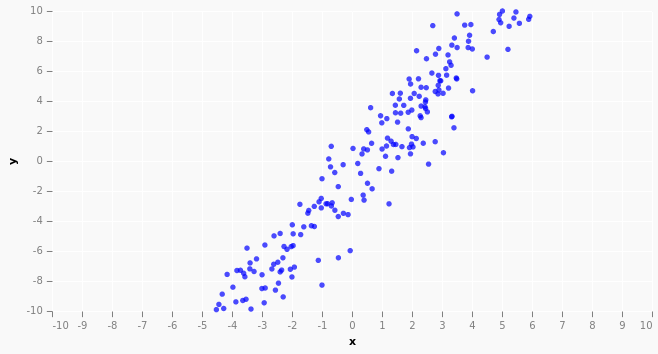

In [28]:
vlShow $ plot (600, 300)
              (L [scatterBlue "x" "y" (-10, 10) (-10, 10)])
              (Cols [("x", VL.Numbers (xValue <$> points3)), ("y", VL.Numbers (yValue <$> points3))])

Rejection sampling is often not very efficient, but it is simple and straight forward.
By design, most rejected samples are in low probability regions, and it is thus crucial to choose an initial distribution that is concentrated around high probability regions—if we know where they are.
Long story short, we now have data samples that correspond to the sampling distribution identified by `Params {slope=2.3, intercept=(-1.2), noiseStd=2.0}`.

### Linear Regression - Inferring Slope and Intercept

Can we find the parameters that we have used from the data points only?
In other words, can we find the _specific_ distribution that generated the data points from the _family_ of distributions that our model describes?
Well, at least we can assess how probable it is that a distribution in the model generates the data - the likelihood.
With this likelihood, we can score the distributions from the prior distribution of parameters `priorParams` that we have defined before.
Now pay attention, here is the inference recipe, in English and in Haskell:

_pull out a model parameter sample from the prior distribution and score it with the likelihood to observe all data points_:

In [29]:
postParams :: MonadInfer m => m Params -> [Data] -> m Params
postParams pr obs = do
  param <- pr
  forM_ obs (\point -> score (likelihood param point))
  return param

Line 4: Avoid lambda
Found:
\ point -> score (likelihood param point)
Why not:
score . likelihood param

Remember, the `score` function multiplies the relative probability of a model parameter sample with a factor:
Our belief in model parameters that correspond to distributions that _likely_ generate what we observe are multiplied with a _high_ number.
Our belief in model parameters that correspond to distributions that are _unlikely_ to generate what we observe are multiplied with a _low_ number.
We thus update the prior probabilities of model parameters and get a new posterior distribution of model parameters.

But now the question is again how we can sample from this posterior distribution.
The sampler that we use to handle the `score` operation, that is updating relative probabilities of samples in a distribution, is [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm):

In [30]:
mkSampler = prior . mh 1000
modelsamples <- sampleIOfixed $ mkSampler $ postParams priorParams points3

Here is how the posterior distribution looks like:

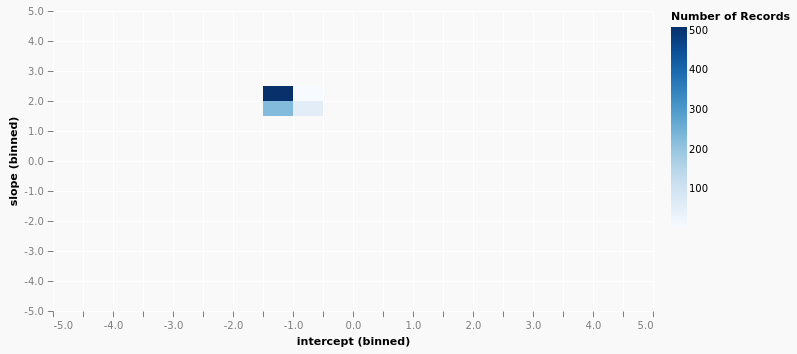

In [31]:
stable = take 800 modelsamples
vlShow $ plot (600, 300)
              (L [density2DPlot "intercept" "slope" (-5, 5) (-5, 5)])
              (Cols [("intercept", VL.Numbers (intercept <$> stable)), ("slope", VL.Numbers (slope <$> stable))])

This posterior distribution over model parameters describes how likely each sampling distribution in the model generates the observed data.
It peaks at an intercept of `-1.5` - `-1` (the actual value was `-1.2`) and a slope of `1.5`-`2.5` (the actual value was `2.3`).
It seems to work, although we should have probably sampled a bit more to make this more accurate.

You might have noticed that we only use 800/1000 samples here (`take 800` in the code snippet above).
What is the reason? 
If you remember, we saw some random initial samples of the Markov chain in the posterior model parameter distribution in our [last post](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html).
This was because the chain starts at a random position and needs some steps to reach the stable equilibrium that describes the posterior distribution.
We therefore skip the initial part of it.
Why do we use `take` rather than `drop` for this?
Samples are by default appended at the beginning of the list.
Therefore, `take 800` means that we use the `800` latest samples of the chain and drop the `200` initial ones.
Want to know why we skipped 200 and not 20 points? Check out the Appendix for more details!

### Simulating Data

The posterior distribution of the model parameters tells us which distributions likely generate the observed data.
What data would we generate from the sampling distributions defined by this posterior distribution?

Let's write a new sampler for a _predictive distribution_:

In [32]:
predDist :: MonadInfer m => m Params -> m Data
predDist paramDist = do
  params <- paramDist
  point <- likelihoodDist params
  return point

Line 2: Redundant return
Found:
do params <- paramDist
   point <- likelihoodDist params
   return point
Why not:
do params <- paramDist
   likelihoodDist params

We draw samples from it with Metropolis-Hastings:

In [33]:
mkSampler = prior . mh 40000 
pts <- sampleIOfixed $  mkSampler $ predDist $ postParams priorParams points3
predPoints = take (length pts - 100) pts

The data looks like this:

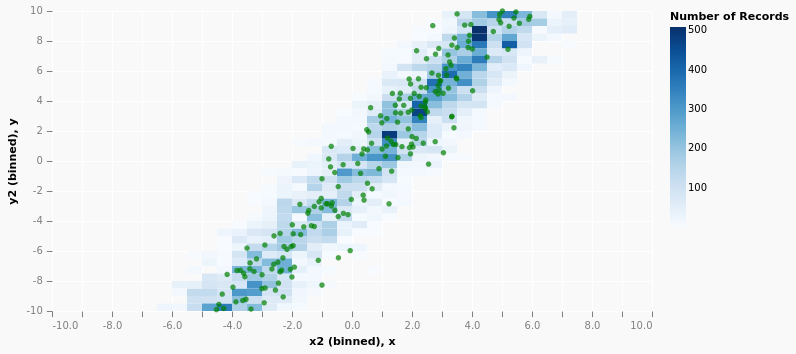

In [34]:
vlShow $ plot (600, 300)
              (L [density2DPlot "x2" "y2" (-10, 10) (-10, 10), scatterGreen "x" "y" (-10, 10) (-10, 10)])
              (Cols [("x", VL.Numbers (xValue <$> points3)), ("y", VL.Numbers (yValue <$> points3)),
                     ("x2", VL.Numbers (xValue <$> predPoints)), ("y2", VL.Numbers (yValue <$> predPoints))])

This looks quite OK; the simulated distribution (blue) looks similar to the original data (green).
Although we have drawn 40000 samples with MCMC, you see that the distribution is still not as smooth and nice as we would expect.
Of course, we could sample more, but we really should think about our sampling method and see how we adapt it to the problem and make it more efficient.
But, that's not the aim of this post, so we'll postpone that discussion to later in our series.

Note that `predDist` looks _very_ similar to `likelihoodDist`.
The fundamental difference is that the former takes a distribution, in this case the _posterior predictive_ distribution `postParams priorParams points :: m Params` as input, whereas the latter accepts a single value, in this case `params :: Params`.
The resulting distributions, that we are comparing in the plot above, `likelihoodDist params` and `predDist (postParams priorParams points)` look similar—and it is fairly obvious why:
The posterior predictive distribution peaks at values close to `params` and is zero elsewhere.
Why does it peak at these values?
Well, we gave a high score to those model parameters that are likely to produce the same data as `params0`.
This explanation becomes somewhat circular, but it illustrates again _why_ the predicted points look like the ones that we used for fitting by design.

### Conclusions

We went step by step through the modeling process with `monad-bayes` and a linear regression example.
We learned that the model setup takes only a few lines of code, that is the implementation of `Data`, `Params`, and `likelihood` plus the definition of `prior` and `posterior`.
With these initial definitions, the composability of Haskell functions allows us to rapidly get new distributions like `samplingDistribution` or a `predDist`.
Involved and with big implications is the sampling process, the choice of the sampling technique, and how it is adapted to the current situation.
To sample, we used Metropolis-Hastings and rejection sampling but many other sampling strategies exist.

We hope you enjoyed this second post in our Probabilistic Programming with monad‑bayes Series and learned lots! A central aspect of `monad-bayes` is to enable the modeller to use and compose different sampling techniques for their models. Now, you're ready to start getting into such questions in our next post. We hope you join us!

### Appendix - Stability of the Monte Carlo chain

The Markov chain, that we used to sample in this blog post, is a stochastic process that cycles through possible models.
Models that are more likely are hit more often than models that are less likely, and over time we thus recover the model distribution that we are interested in.
However, typically it needs a while to reach the unique stationary distribution that is equal to the model distribution distribution.
A simple way to assess when it becomes stationary is to look at the likelihood that it reaches:

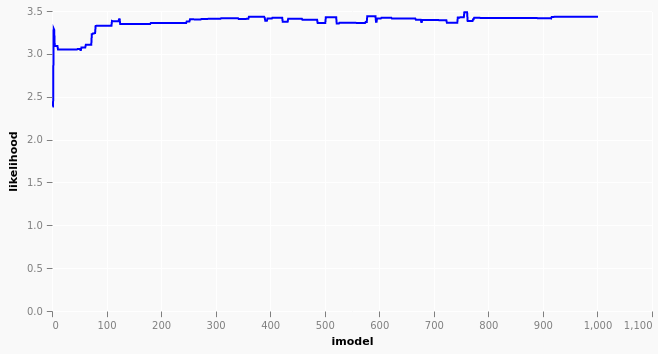

In [35]:
likelihoods = [Numeric.Log.sum (map prob points3) | param <- modelsamples, let prob = likelihood param]
nsamples = length likelihoods

vlShow $ plot (600, 300)
              (L [linePlot "imodel" "likelihood"])
              (Cols [("imodel", VL.Numbers $ fromIntegral <$> [nsamples, nsamples-1..0]), ("likelihood", VL.Numbers (ln <$> likelihoods))])

Our MC chain is non-stationary in the beginning at `imodel` values up to 100, and then reaches stationary behaviour.

### Notes

We use [this GitHub version](https://github.com/adscib/monad-bayes/tree/f55d9fa9d24d169d53bb03598306ee8c46b5fc11) of`monad-bayes`in our posts and notebooks since it's neither on Hackage nor Stackage right now.